# IMM Systems Genomics Notebook (IMMSG)
A reproducible, **cell-by-cell** genomics workflow for your **inner mitochondrial membrane (IMM modules)**.

This notebook:
- Builds your **10 curated IMM layers** as gene sets.
- Ingests bulk expression (or runs a **demo simulation**).
- Computes **rank-based module activity** per sample (fast ssGSEA-like AUC).
- Computes composite system metrics: **Coupling Integrity Score** and **Leak/Uncoupling Index**.
- Runs **differential module activity** and **gene-level DE** (two-group).
- Learns **latent axes** (PCA/NMF) and a **partial-correlation module network** (Graphical Lasso).
- Visualizes everything **inline** and writes outputs to `outputs_immsg/`.

To use your own data, set `EXPR_PATH` and `META_PATH` in Section 3.


In [2]:
# 0) Imports
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF
from sklearn.covariance import GraphicalLassoCV

print("Imports OK")

Imports OK


## 1) Define your IMM gene sets (10 layers)

In [5]:
def imm_gene_sets():
    gs = {}
    gs["ETC_Complex_I"] = [
        "NDUFS1","NDUFS2","NDUFS3","NDUFS7","NDUFS8","NDUFV1","NDUFV2",
        "MT-ND1","MT-ND2","MT-ND3","MT-ND4","MT-ND4L","MT-ND5","MT-ND6"
    ]
    gs["ETC_Complex_II"] = ["SDHA","SDHB","SDHC","SDHD"]
    gs["ETC_Complex_III"] = ["UQCRC1","UQCRC2","UQCRFS1","MT-CYB"]
    gs["ETC_Complex_IV"] = [
        "MT-CO1","MT-CO2","MT-CO3",
        "COX4I1","COX5A","COX5B","COX6A1","COX6B1","COX7A2","COX7C","COX8A"
    ]
    gs["CoQ_Biosynthesis"] = ["COQ2","COQ3","COQ4","COQ5","COQ6","COQ7","COQ8A","COQ8B","COQ9","PDSS1","PDSS2"]
    gs["Cytochrome_c"] = ["CYCS"]
    gs["ATP_Synthase_Core"] = [
        "ATP5F1A","ATP5F1B","ATP5F1G","ATP5MC1","ATP5MC2","ATP5MC3",
        "ATP5F1E","ATP5PF","ATP5PD","ATP5MG","ATP5ME","ATP5MF","ATPIF1"
    ]
    gs["SLC25_Nucleotide_Phosphate"] = ["SLC25A4","SLC25A5","SLC25A6","SLC25A31","SLC25A3","SLC25A24","SLC25A25","SLC25A41"]
    gs["Transport_Carbon_TCA"] = ["MPC1","MPC2","SLC25A1","SLC25A11","SLC25A10","SLC25A21"]
    gs["Transport_AA_Urea"] = ["SLC25A12","SLC25A13","SLC25A22","SLC25A2","SLC25A15"]
    gs["Transport_FattyAcid"] = ["SLC25A20"]
    gs["Transport_OneCarbon"] = ["SLC25A26"]
    gs["Calcium_Uptake_MCU"] = ["MCU","MICU1","MICU2","SMDT1"]
    gs["Calcium_Efflux_NCLX"] = ["SLC8B1"]
    gs["Proton_Leak_UCP"] = ["UCP2","UCP3","LETM1"]
    gs["TIM23_Pathway"] = ["TIMM23","TIMM17A","TIMM17B","TIMM50","PAM16","PAM18","HSPA9","DNAJC19","PMPCB"]
    gs["TIM22_Pathway"] = ["TIMM22","TIMM9","TIMM10","TIMM8A","TIMM13"]
    gs["Insertase_OXA1L"] = ["OXA1L"]
    gs["MICOS_Complex"] = ["IMMT","MIC10","CHCHD3","CHCHD6","QIL1","APOO","APOOL"]
    gs["Cristae_Regulator_OPA1"] = ["OPA1"]
    gs["Contact_Fusion_Fission_Linked"] = ["SAMM50","MFN1","MFN2","DNM1L"]
    gs["AAA_Proteases"] = ["AFG3L2","SPG7","YME1L1"]
    gs["Stress_Protease_OMA1"] = ["OMA1"]
    gs["Cardiolipin_Biosyn_Remodel"] = ["TAMM41","PGS1","PTPMT1","CRLS1","TAZ"]
    gs["Respiratory_Assembly_Factors"] = ["BCS1L"]
    return gs

GENE_SETS = imm_gene_sets()
print("Modules:", len(GENE_SETS))
list(GENE_SETS.keys())[:8]

Modules: 25


['ETC_Complex_I',
 'ETC_Complex_II',
 'ETC_Complex_III',
 'ETC_Complex_IV',
 'CoQ_Biosynthesis',
 'Cytochrome_c',
 'ATP_Synthase_Core',
 'SLC25_Nucleotide_Phosphate']

## 2) Helper functions

In [8]:
def ensure_dir(path: str) -> None:
    os.makedirs(path, exist_ok=True)

def harmonize_gene_index(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.index = [str(x).strip().upper() for x in df.index]
    return df

def log1p_expr(x: pd.DataFrame) -> pd.DataFrame:
    return np.log1p(x)

def auc_rank_score(expr: pd.DataFrame, genes):
    genes = [str(g).strip().upper() for g in genes]
    present = [g for g in genes if g in expr.index]
    if len(present) == 0:
        return pd.Series(np.nan, index=expr.columns)

    ranks = expr.rank(axis=0, method="average", ascending=True)
    n = expr.shape[0]
    ranks01 = (ranks - 1) / max(1, (n - 1))
    return ranks01.loc[present].mean(axis=0)

def compute_module_matrix(expr: pd.DataFrame, gene_sets):
    mm = []
    for name, genes in gene_sets.items():
        mm.append(auc_rank_score(expr, genes).rename(name))
    return pd.DataFrame(mm)

def benjamini_hochberg(pvals):
    pvals = np.asarray(pvals, dtype=float)
    q = np.full_like(pvals, np.nan)
    mask = ~np.isnan(pvals)
    if mask.sum() == 0:
        return q
    p = pvals[mask]
    n = len(p)
    order = np.argsort(p)
    ranked = p[order]
    bh = ranked * n / (np.arange(1, n+1))
    bh = np.minimum.accumulate(bh[::-1])[::-1]
    out = np.empty_like(p)
    out[order] = np.minimum(bh, 1.0)
    q[mask] = out
    return q

def ttest_two_group(values: pd.Series, groups: pd.Series):
    df = pd.DataFrame({"v": values, "g": groups}).dropna()
    uniq = df["g"].unique()
    if len(uniq) != 2:
        return np.nan, np.nan
    a = df.loc[df["g"] == uniq[0], "v"].values
    b = df.loc[df["g"] == uniq[1], "v"].values
    if len(a) < 2 or len(b) < 2:
        return np.nan, np.nan
    t, p = stats.ttest_ind(a, b, equal_var=False)
    return float(t), float(p)

def differential_module_activity(module_scores: pd.DataFrame, meta: pd.DataFrame, group_col: str):
    groups = meta[group_col]
    out = []
    for m in module_scores.index:
        t, p = ttest_two_group(module_scores.loc[m], groups)
        out.append({"module": m, "t": t, "p": p})
    res = pd.DataFrame(out)
    res["q"] = benjamini_hochberg(res["p"].values)
    return res.sort_values(["q","p"], ascending=True)

def differential_expression(expr_log: pd.DataFrame, meta: pd.DataFrame, group_col: str):
    groups = meta[group_col]
    uniq = groups.dropna().unique()
    if len(uniq) != 2:
        raise ValueError("group_col must have exactly 2 groups.")
    g1, g2 = uniq[0], uniq[1]
    rows = []
    for gene in expr_log.index:
        t, p = ttest_two_group(expr_log.loc[gene], groups)
        m1 = float(expr_log.loc[gene, groups == g1].mean())
        m2 = float(expr_log.loc[gene, groups == g2].mean())
        rows.append({"gene": gene, "t": t, "p": p, f"mean_{g1}": m1, f"mean_{g2}": m2, "delta_log1p": (m2 - m1)})
    res = pd.DataFrame(rows)
    res["q"] = benjamini_hochberg(res["p"].values)
    return res.sort_values(["q","p"], ascending=True)

def safe_mean(module_scores: pd.DataFrame, mods):
    present = [m for m in mods if m in module_scores.index]
    if not present:
        return pd.Series(np.nan, index=module_scores.columns)
    return module_scores.loc[present].mean(axis=0)

def coupling_integrity_score(module_scores: pd.DataFrame):
    etc = safe_mean(module_scores, ["ETC_Complex_I","ETC_Complex_II","ETC_Complex_III","ETC_Complex_IV"])
    atp = safe_mean(module_scores, ["ATP_Synthase_Core"])
    logistics = safe_mean(module_scores, ["SLC25_Nucleotide_Phosphate","Transport_Carbon_TCA","Transport_AA_Urea","Transport_FattyAcid","Transport_OneCarbon"])
    cristae = safe_mean(module_scores, ["MICOS_Complex","Cristae_Regulator_OPA1"])
    import_insert = safe_mean(module_scores, ["TIM23_Pathway","TIM22_Pathway","Insertase_OXA1L"])
    proteostasis = safe_mean(module_scores, ["AAA_Proteases","Stress_Protease_OMA1"])
    leak = safe_mean(module_scores, ["Proton_Leak_UCP"])
    cis = (0.30*etc + 0.20*atp + 0.15*logistics + 0.15*cristae + 0.10*import_insert + 0.10*proteostasis) - 0.20*leak
    return cis.rename("CouplingIntegrityScore")

def leak_uncoupling_index(module_scores: pd.DataFrame):
    idx = pd.Series(0.0, index=module_scores.columns)
    if "Proton_Leak_UCP" in module_scores.index:
        idx += module_scores.loc["Proton_Leak_UCP"]
    if "Stress_Protease_OMA1" in module_scores.index:
        idx += module_scores.loc["Stress_Protease_OMA1"]
    etc_mods = [m for m in ["ETC_Complex_I","ETC_Complex_II","ETC_Complex_III","ETC_Complex_IV"] if m in module_scores.index]
    if etc_mods:
        idx -= module_scores.loc[etc_mods].mean(axis=0)
    return idx.rename("LeakUncouplingIndex")

def infer_latent_axes(module_scores: pd.DataFrame, n_components: int = 3):
    X = module_scores.T.values
    modules = module_scores.index.tolist()
    Xz = StandardScaler().fit_transform(X)

    pca = PCA(n_components=min(n_components, Xz.shape[1]))
    Zp = pca.fit_transform(Xz)
    pca_load = pd.DataFrame(pca.components_.T, index=modules, columns=[f"PC{i+1}" for i in range(pca.n_components_)])
    pca_var = pd.DataFrame({"explained_variance_ratio": pca.explained_variance_ratio_},
                           index=[f"PC{i+1}" for i in range(pca.n_components_)])

    Xpos = Xz - Xz.min() + 1e-6
    nmf = NMF(n_components=min(n_components, Xpos.shape[1]), init="nndsvda", random_state=0, max_iter=2000)
    W = nmf.fit_transform(Xpos)
    H = nmf.components_
    nmf_load = pd.DataFrame(H.T, index=modules, columns=[f"NMF{i+1}" for i in range(H.shape[0])])

    return pca_load, pca_var, nmf_load, Zp, W

def partial_corr_edges(module_scores: pd.DataFrame):
    X = module_scores.T.values
    modules = module_scores.index.tolist()
    Xz = StandardScaler().fit_transform(X)
    gl = GraphicalLassoCV()
    gl.fit(Xz)
    precision = gl.precision_
    d = np.sqrt(np.diag(precision))
    pcorr = -precision / np.outer(d, d)
    np.fill_diagonal(pcorr, 1.0)

    edges = []
    for i in range(len(modules)):
        for j in range(i+1, len(modules)):
            edges.append({"module_a": modules[i], "module_b": modules[j], "partial_corr": float(pcorr[i, j])})
    return pd.DataFrame(edges).sort_values("partial_corr", ascending=False)

## 3) Load your data (or run demo)

In [11]:
EXPR_PATH = None  # e.g. "expr.csv"
META_PATH = None  # e.g. "meta.csv"
GROUP_COL = "group"

OUTDIR = "outputs_immsg"
ensure_dir(OUTDIR)
ensure_dir(os.path.join(OUTDIR, "figures"))
ensure_dir(os.path.join(OUTDIR, "tables"))

def load_matrix(path: str) -> pd.DataFrame:
    sep = "\t" if path.lower().endswith(".tsv") else ","
    return pd.read_csv(path, sep=sep, index_col=0)

def load_meta(path: str) -> pd.DataFrame:
    sep = "\t" if path.lower().endswith(".tsv") else ","
    df = pd.read_csv(path, sep=sep)
    if "sample" in df.columns:
        df = df.set_index("sample")
    else:
        df = df.set_index(df.columns[0])
    return df

def simulate_expression(gene_sets, n_genes_bg=8000, n_samples=80, seed=1):
    rng = np.random.default_rng(seed)
    all_genes = set()
    for gset in gene_sets.values():
        all_genes.update([g.upper() for g in gset])
    all_genes = sorted(all_genes)
    bg = [f"GENE{idx}" for idx in range(1, n_genes_bg+1)]
    genes = [g.upper() for g in (all_genes + bg)]

    samples = [f"S{idx:03d}" for idx in range(n_samples)]
    group = np.array(["Control"]*(n_samples//2) + ["Case"]*(n_samples - n_samples//2))
    rng.shuffle(group)
    meta = pd.DataFrame({"sample": samples, "group": group}).set_index("sample")

    X = rng.lognormal(mean=1.5, sigma=0.6, size=(len(genes), n_samples))
    expr = pd.DataFrame(X, index=genes, columns=samples)

    def bump(mod, effect):
        for g in gene_sets.get(mod, []):
            g = g.upper()
            if g in expr.index:
                expr.loc[g, meta["group"] == "Case"] *= effect

    for m in ["ETC_Complex_I","ETC_Complex_II","ETC_Complex_III","ETC_Complex_IV","ATP_Synthase_Core","MICOS_Complex"]:
        bump(m, 0.75)
    bump("Proton_Leak_UCP", 1.5)
    bump("Stress_Protease_OMA1", 1.4)

    return expr, meta

if EXPR_PATH is None or META_PATH is None:
    print("Running DEMO simulation...")
    expr, meta = simulate_expression(GENE_SETS, n_genes_bg=8000, n_samples=80, seed=1)
else:
    expr = load_matrix(EXPR_PATH)
    meta = load_meta(META_PATH)

expr = harmonize_gene_index(expr)
common = [c for c in expr.columns if c in meta.index]
expr = expr.loc[:, common]
meta = meta.loc[common, :]

print("Expression:", expr.shape, "Meta:", meta.shape)
meta[GROUP_COL].value_counts()

Running DEMO simulation...
Expression: (8124, 80) Meta: (80, 1)


group
Case       40
Control    40
Name: count, dtype: int64

## 4) Compute module activities and visualize

,S000,S001,S002,S003,S004,S005,S006,S007,S008,S009,...,S070,S071,S072,S073,S074,S075,S076,S077,S078,S079
module,,,,,,,,,,,,,,,,,,,,,
ETC_Complex_I,0.417887,0.228962,0.517437,0.523127,0.387058,0.490090,0.471835,0.363298,0.634846,0.473215,...,0.336276,0.239848,0.460720,0.418767,0.305200,0.395271,0.312622,0.239699,0.297339,0.362815
ETC_Complex_II,0.431675,0.643635,0.425582,0.472362,0.482550,0.659116,0.453312,0.401607,0.381571,0.300412,...,0.404930,0.410439,0.498400,0.621968,0.215130,0.603749,0.304106,0.463406,0.554629,0.433214
ETC_Complex_III,0.301182,0.303213,0.404284,0.392250,0.372369,0.435984,0.549151,0.606149,0.411301,0.557183,...,0.413148,0.122153,0.835621,0.355287,0.223747,0.485627,0.483504,0.431029,0.243629,0.435615
ETC_Complex_IV,0.421721,0.245487,0.562354,0.439247,0.454993,0.488971,0.397480,0.463991,0.422392,0.510134,...,0.353105,0.424160,0.521001,0.274104,0.370866,0.417401,0.331214,0.393507,0.392253,0.430618
CoQ_Biosynthesis,0.521863,0.542690,0.484964,0.449543,0.496659,0.561761,0.417557,0.391067,0.680167,0.404049,...,0.647544,0.606829,0.419829,0.476044,0.402583,0.549909,0.515304,0.596678,0.543295,0.364218


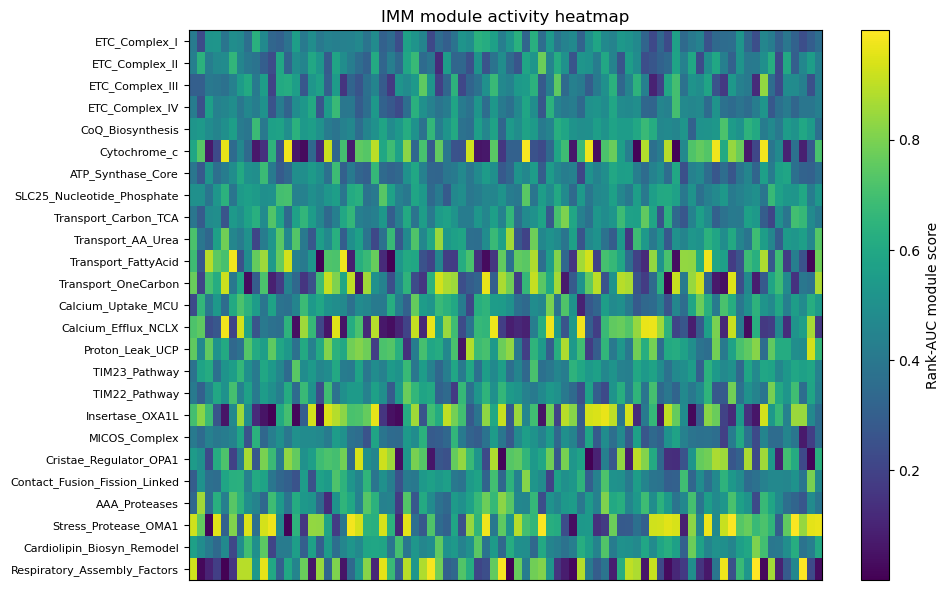

In [14]:
expr_log = log1p_expr(expr)
module_scores = compute_module_matrix(expr_log, GENE_SETS)
module_scores.index.name = "module"

module_scores.to_csv(os.path.join(OUTDIR, "tables", "module_scores_auc.csv"))

display(module_scores.head())

plt.figure(figsize=(10, 6))
plt.imshow(module_scores.values, aspect="auto")
plt.yticks(range(module_scores.shape[0]), module_scores.index, fontsize=8)
plt.xticks([])
plt.colorbar(label="Rank-AUC module score")
plt.title("IMM module activity heatmap")
plt.tight_layout()
plt.show()

## 5) Composite scores and group plots

,CouplingIntegrityScore,LeakUncouplingIndex
S000,0.321880,1.289267
S001,0.319652,0.874558
S002,0.306348,0.294509
S003,0.393722,1.008886
S004,0.347724,0.495287


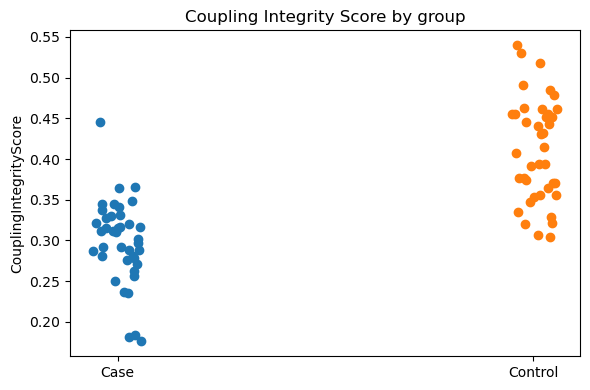

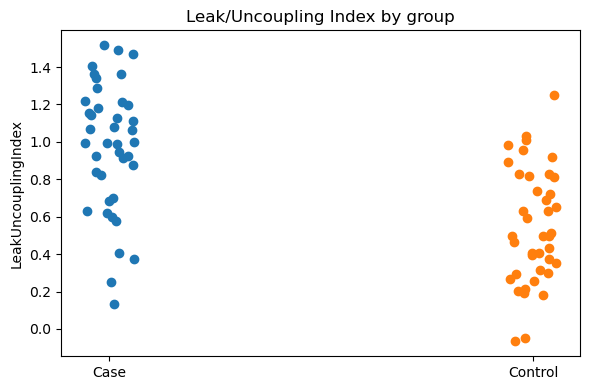

In [17]:
cis = coupling_integrity_score(module_scores)
lui = leak_uncoupling_index(module_scores)
scores = pd.concat([cis, lui], axis=1)
scores.to_csv(os.path.join(OUTDIR, "tables", "composite_scores.csv"))

display(scores.head())

def stripplot(series, meta, group_col, title):
    df = pd.DataFrame({"score": series, "group": meta[group_col]}).dropna()
    groups = df["group"].unique()
    plt.figure(figsize=(6, 4))
    for i, g in enumerate(groups):
        y = df.loc[df["group"] == g, "score"].values
        x = np.full_like(y, i, dtype=float) + (np.random.rand(len(y)) - 0.5) * 0.12
        plt.scatter(x, y)
    plt.xticks(range(len(groups)), groups)
    plt.ylabel(series.name)
    plt.title(title)
    plt.tight_layout()
    plt.show()

stripplot(cis, meta, GROUP_COL, "Coupling Integrity Score by group")
stripplot(lui, meta, GROUP_COL, "Leak/Uncoupling Index by group")

## 6) Differential module activity and visualization

,module,t,p,q
6,ATP_Synthase_Core,-9.436338,1.567145e-14,3.917863e-13
0,ETC_Complex_I,-8.241638,3.248010e-12,4.060013e-11
3,ETC_Complex_IV,-7.633982,5.116712e-11,4.263927e-10
18,MICOS_Complex,-5.372120,7.975872e-07,4.984920e-06
14,Proton_Leak_UCP,4.996465,3.963776e-06,1.981888e-05
2,ETC_Complex_III,-4.067770,1.127428e-04,4.697616e-04
22,Stress_Protease_OMA1,1.958489,5.374927e-02,1.839027e-01
21,AAA_Proteases,-1.919653,5.884887e-02,1.839027e-01
1,ETC_Complex_II,-1.761213,8.213886e-02,2.281635e-01
5,Cytochrome_c,1.671146,9.881338e-02,2.470334e-01


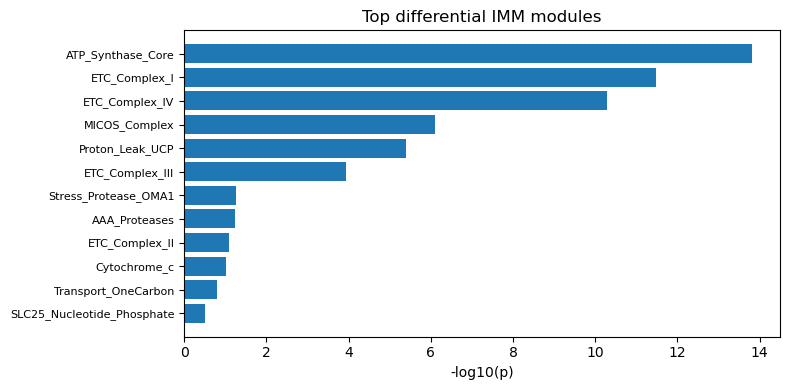

In [20]:
dma = differential_module_activity(module_scores, meta, GROUP_COL)
dma.to_csv(os.path.join(OUTDIR, "tables", "diff_module_activity.csv"), index=False)

display(dma.head(15))

top = dma.dropna().head(12)
plt.figure(figsize=(8, 4))
plt.barh(range(len(top)), -np.log10(top["p"].values))
plt.yticks(range(len(top)), top["module"].values, fontsize=8)
plt.gca().invert_yaxis()
plt.xlabel("-log10(p)")
plt.title("Top differential IMM modules")
plt.tight_layout()
plt.show()

## 7) Differential expression (IMM gene universe)

In [23]:
imm_genes = sorted({g.upper() for genes in GENE_SETS.values() for g in genes})
expr_imm = expr_log.loc[[g for g in imm_genes if g in expr_log.index]]

print("IMM genes present:", expr_imm.shape[0])

if meta[GROUP_COL].dropna().nunique() == 2 and expr_imm.shape[0] >= 5:
    de = differential_expression(expr_imm, meta, GROUP_COL)
    de.to_csv(os.path.join(OUTDIR, "tables", "diff_expression_IMM_genes.csv"), index=False)
    display(de.head(20))
else:
    print("DE skipped (need 2 groups and >=5 IMM genes present).")

IMM genes present: 124


,gene,t,p,mean_Case,mean_Control,delta_log1p,q
15,ATPIF1,-4.518487,0.000025,1.494938,1.968142,0.473204,0.001750
14,ATP5PF,-4.450711,0.000028,1.364068,1.841379,0.477311,0.001750
42,LETM1,4.325716,0.000046,2.138958,1.621134,-0.517824,0.001921
58,MT-ND4,-4.095311,0.000109,1.419955,1.853919,0.433963,0.003370
56,MT-ND2,-3.855269,0.000236,1.423929,1.860249,0.436320,0.005628
46,MIC10,-3.814151,0.000272,1.347542,1.715809,0.368267,0.005628
12,ATP5MG,-3.626014,0.000512,1.380208,1.768787,0.388579,0.009069
53,MT-CO3,-3.481186,0.000821,1.364146,1.701386,0.337239,0.011429
32,COX6B1,-3.478480,0.000829,1.461253,1.793668,0.332415,0.011429
68,NDUFV2,-3.455671,0.000978,1.435613,1.844151,0.408538,0.012132


## 8) Latent axes (PCA and NMF)

,explained_variance_ratio
PC1,0.133055
PC2,0.080041
PC3,0.068242


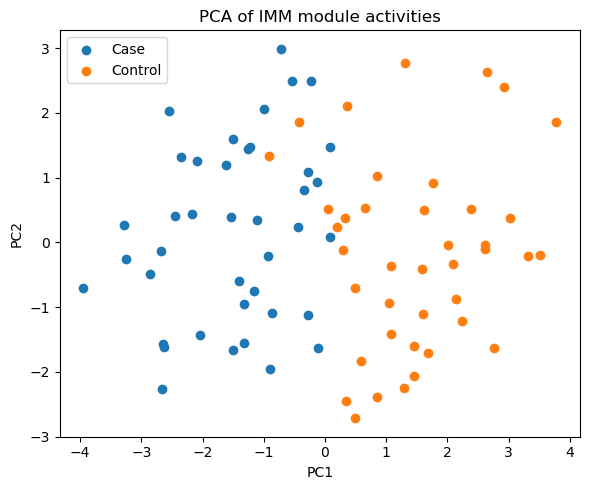

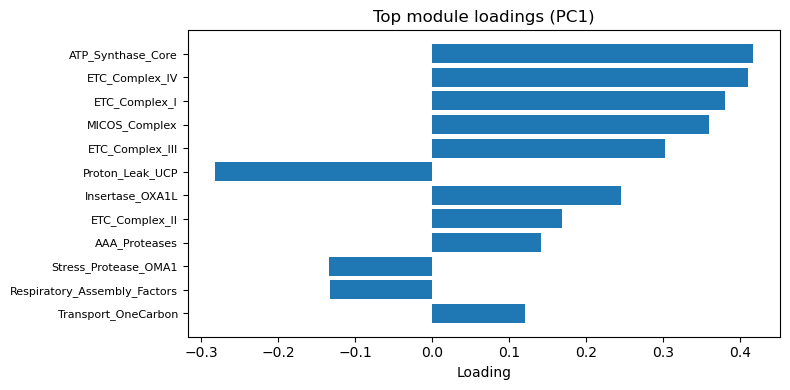

In [26]:
pca_load, pca_var, nmf_load, Zp, W = infer_latent_axes(module_scores, n_components=3)
pca_load.to_csv(os.path.join(OUTDIR, "tables", "pca_loadings.csv"))
pca_var.to_csv(os.path.join(OUTDIR, "tables", "pca_variance.csv"))
nmf_load.to_csv(os.path.join(OUTDIR, "tables", "nmf_loadings.csv"))

display(pca_var)

plt.figure(figsize=(6, 5))
groups = meta[GROUP_COL].values
uniq = pd.unique(groups)
for g in uniq:
    mask = (groups == g)
    plt.scatter(Zp[mask, 0], Zp[mask, 1], label=str(g))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of IMM module activities")
plt.legend()
plt.tight_layout()
plt.show()

pc1 = pca_load["PC1"].sort_values(key=lambda x: np.abs(x), ascending=False).head(12)
plt.figure(figsize=(8, 4))
plt.barh(range(len(pc1)), pc1.values)
plt.yticks(range(len(pc1)), pc1.index, fontsize=8)
plt.gca().invert_yaxis()
plt.xlabel("Loading")
plt.title("Top module loadings (PC1)")
plt.tight_layout()
plt.show()

## 9) Partial-correlation network (Graphical Lasso)

,module_a,module_b,partial_corr
71,ETC_Complex_IV,ATP_Synthase_Core,0.265987
5,ETC_Complex_I,ATP_Synthase_Core,0.239601
17,ETC_Complex_I,MICOS_Complex,0.137820
62,ETC_Complex_III,MICOS_Complex,0.116066
93,CoQ_Biosynthesis,Transport_Carbon_TCA,0.100477
47,ETC_Complex_III,ETC_Complex_IV,0.096552
2,ETC_Complex_I,ETC_Complex_IV,0.090454
82,ETC_Complex_IV,Insertase_OXA1L,0.083192
114,Cytochrome_c,Transport_FattyAcid,0.081551
83,ETC_Complex_IV,MICOS_Complex,0.078888


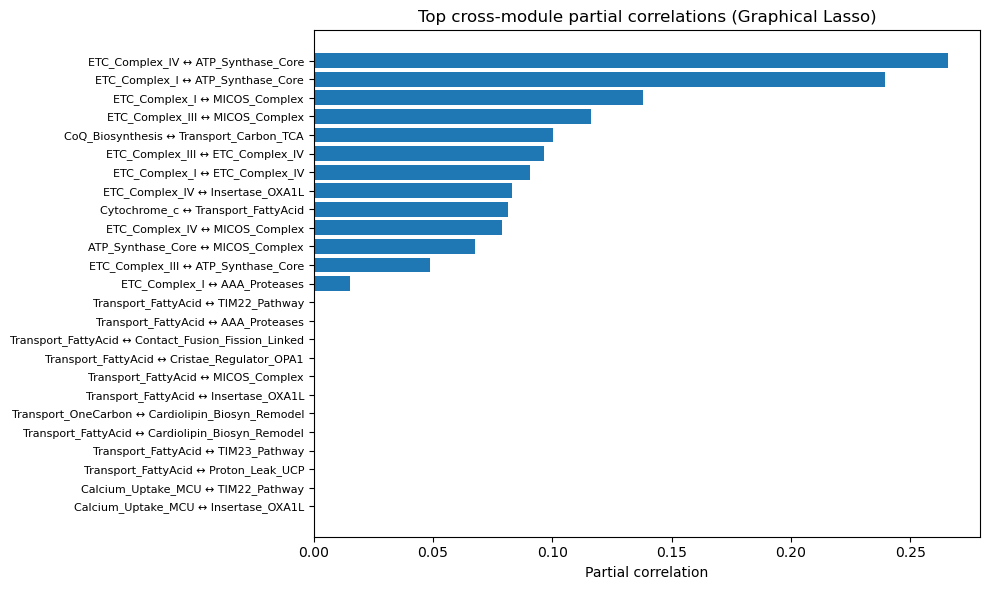

In [29]:
edges = partial_corr_edges(module_scores)
edges.to_csv(os.path.join(OUTDIR, "tables", "module_partial_corr_edges.csv"), index=False)

display(edges.head(10))

top = edges.head(25).copy()
labels = [f"{a} ↔ {b}" for a, b in zip(top["module_a"], top["module_b"])]
plt.figure(figsize=(10, 6))
plt.barh(range(len(top)), top["partial_corr"].values)
plt.yticks(range(len(top)), labels, fontsize=8)
plt.gca().invert_yaxis()
plt.xlabel("Partial correlation")
plt.title("Top cross-module partial correlations (Graphical Lasso)")
plt.tight_layout()
plt.show()

## 10) Export compact JSON summary

In [32]:
summary = {
    "n_samples": int(expr_log.shape[1]),
    "n_genes_total": int(expr_log.shape[0]),
    "n_modules": int(module_scores.shape[0]),
    "group_counts": meta[GROUP_COL].value_counts(dropna=False).to_dict(),
    "top_modules_by_q": dma.head(10)[["module","t","p","q"]].to_dict(orient="records"),
    "top_network_edges": edges.head(10).to_dict(orient="records")
}
with open(os.path.join(OUTDIR, "tables", "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

summary

{'n_samples': 80,
 'n_genes_total': 8124,
 'n_modules': 25,
 'group_counts': {'Case': 40, 'Control': 40},
 'top_modules_by_q': [{'module': 'ATP_Synthase_Core',
   't': -9.43633814380854,
   'p': 1.5671452601751812e-14,
   'q': 3.917863150437953e-13},
  {'module': 'ETC_Complex_I',
   't': -8.241638163572214,
   'p': 3.2480103754717476e-12,
   'q': 4.0600129693396845e-11},
  {'module': 'ETC_Complex_IV',
   't': -7.633982022468002,
   'p': 5.1167121780020404e-11,
   'q': 4.2639268150017e-10},
  {'module': 'MICOS_Complex',
   't': -5.3721197784253585,
   'p': 7.9758720150218e-07,
   'q': 4.984920009388625e-06},
  {'module': 'Proton_Leak_UCP',
   't': 4.996464957969001,
   'p': 3.963776384695291e-06,
   'q': 1.9818881923476453e-05},
  {'module': 'ETC_Complex_III',
   't': -4.067770487361207,
   'p': 0.00011274279557686967,
   'q': 0.00046976164823695697},
  {'module': 'Stress_Protease_OMA1',
   't': 1.958489178278075,
   'p': 0.05374926538824724,
   'q': 0.18390270676558357},
  {'module': '

## 11) Outputs written to disk

In [35]:
print("Output tables in:", os.path.join(OUTDIR, "tables"))
for fn in sorted(os.listdir(os.path.join(OUTDIR, "tables"))):
    print(" -", fn)

Output tables in: outputs_immsg/tables
 - composite_scores.csv
 - diff_expression_IMM_genes.csv
 - diff_module_activity.csv
 - module_partial_corr_edges.csv
 - module_scores_auc.csv
 - nmf_loadings.csv
 - pca_loadings.csv
 - pca_variance.csv
 - summary.json
